In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
import pmdarima as pm

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('27/10/2018', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

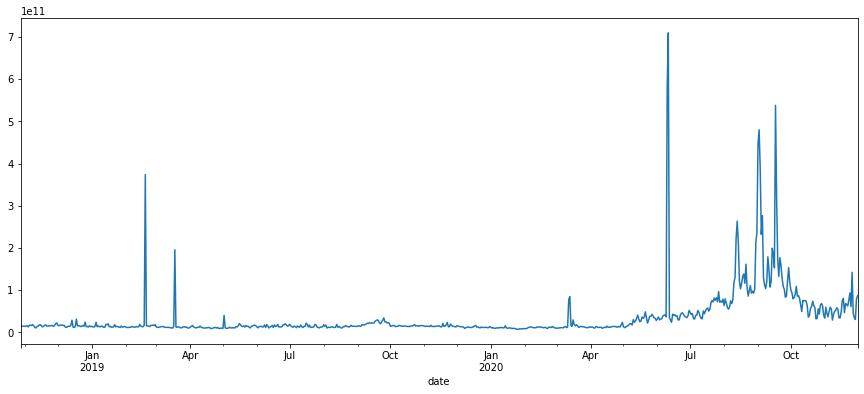

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=datetime.today())
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=datetime.now())

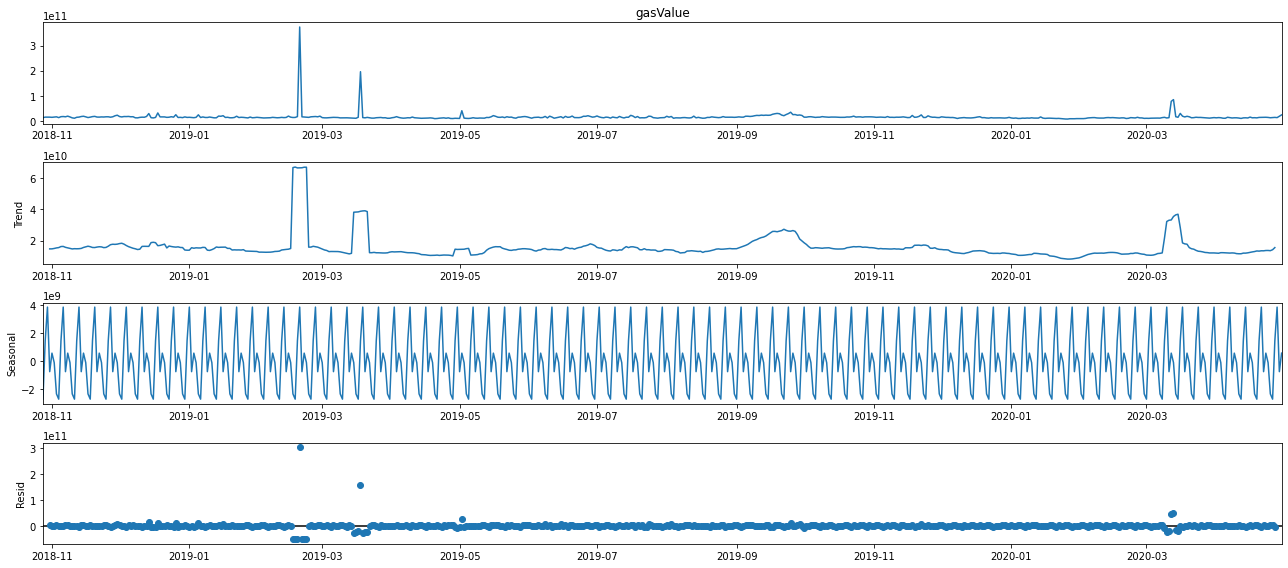

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition1.plot()
plt.show()

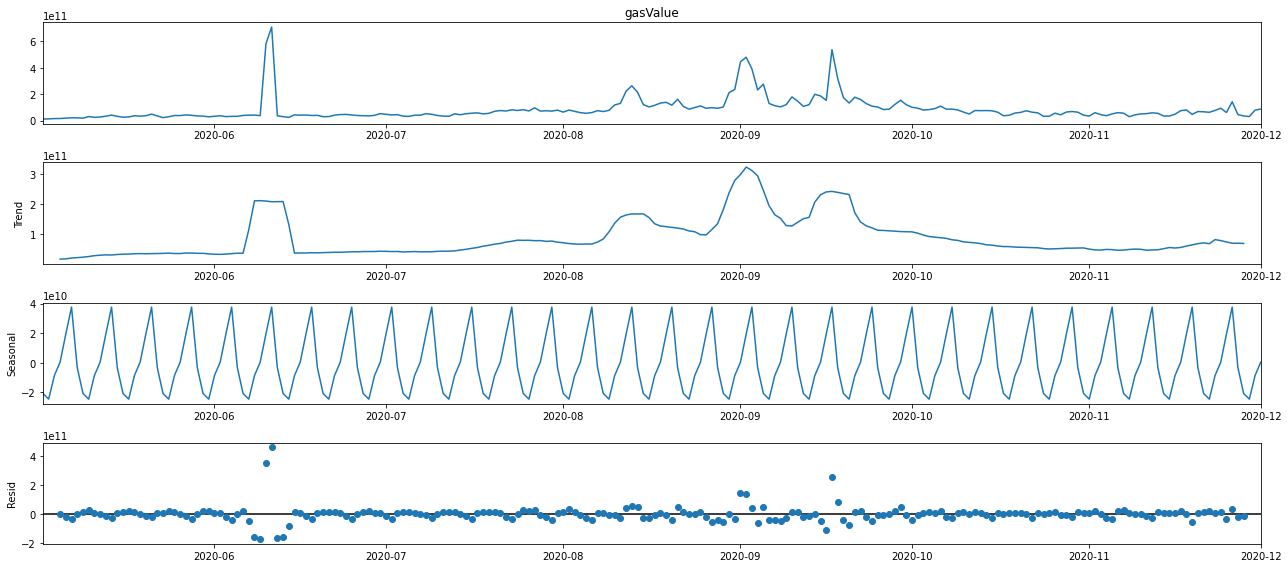

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition2.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [12]:
N = 7
gas_slice1['gasValue'] = gas_slice1['gasValue'] - decomposition1.seasonal
gas_slice1.dropna(inplace=True)

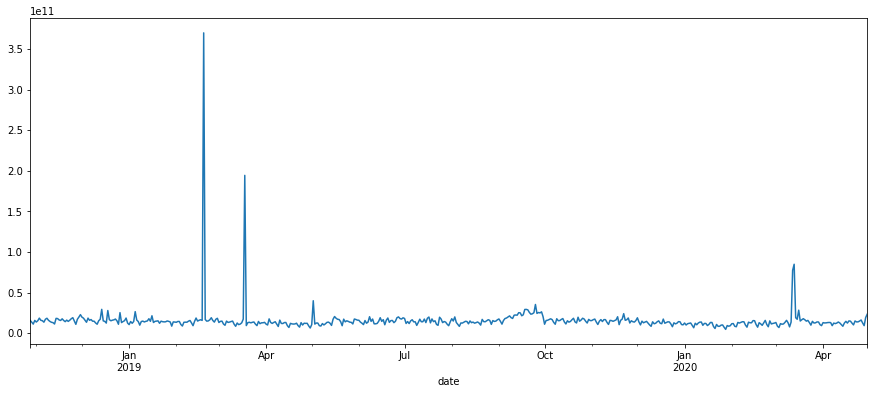

In [13]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [14]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - decomposition2.seasonal
gas_slice2.dropna(inplace=True)

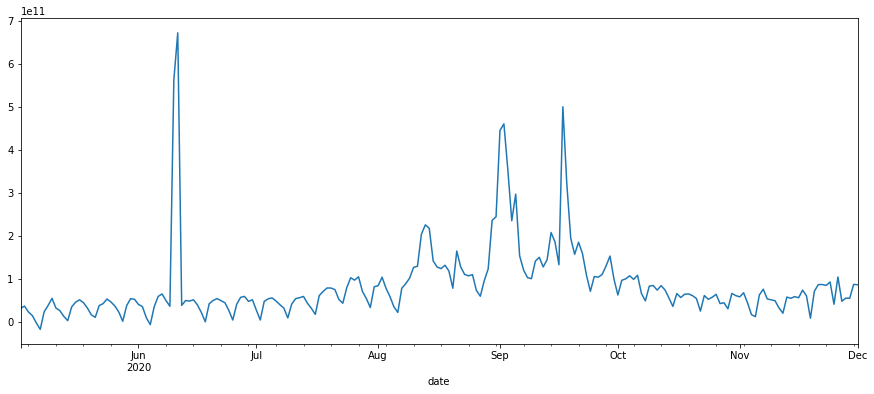

In [15]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [16]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -22.177924
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     550.000000
Critical Value (1%)      -3.442296
Critical Value (5%)      -2.866809
Critical Value (10%)     -2.569576
dtype: float64


In [17]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.636891
P-Value                   0.000110
# Lags Used               2.000000
# Observations Used     211.000000
Critical Value (1%)      -3.461727
Critical Value (5%)      -2.875337
Critical Value (10%)     -2.574124
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [18]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.27838386742606136
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.3940012789959786
p-value: 0.07974082801897475
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# Aragon activity series

Let's check what about the activity series.

In [20]:
aragon: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'aragon_activity.csv'), header=0)
aragon = transform_date_series(df=aragon, date_key='date')

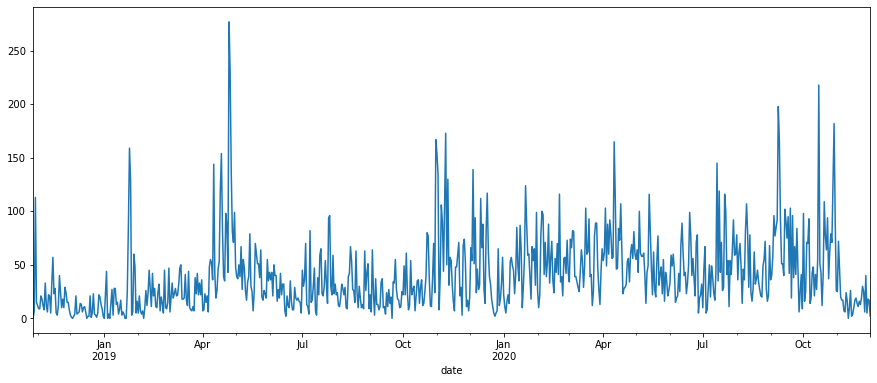

In [21]:
aragon_plot = filter_series(df=aragon, slice1=FIRST_SLICE_DATE, slice2=datetime.today())
aragon_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [22]:
aragon_slice1 = filter_series(df=aragon, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
aragon_slice2 = filter_series(df=aragon, slice1=SECOND_SLICE_DATE, slice2=datetime.now())

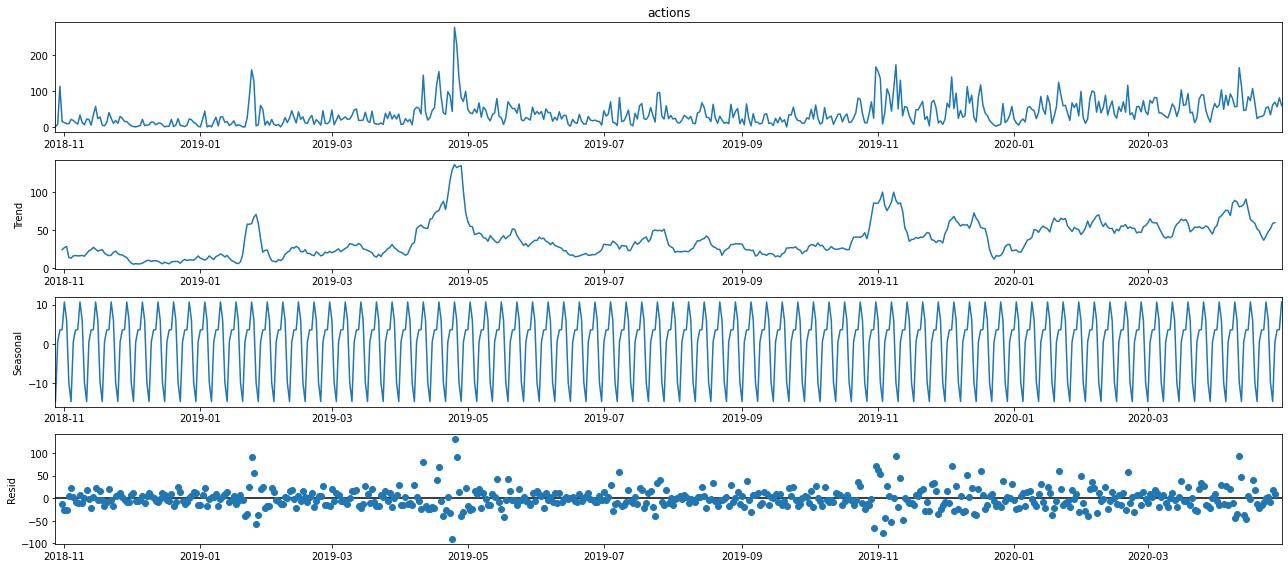

In [23]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=aragon_slice1['actions'], model='additive')
fig = decomposition1.plot()
plt.show()

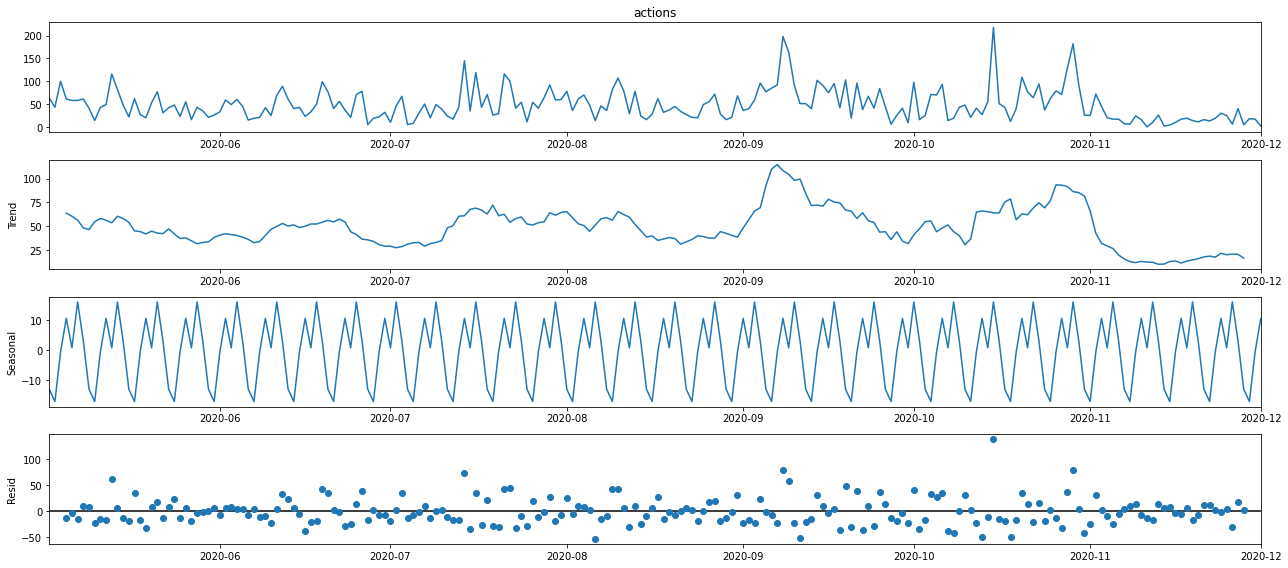

In [24]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=aragon_slice2['actions'], model='additive')
fig = decomposition2.plot()
plt.show()

In [25]:
aragon_slice1['actions'] = aragon_slice1['actions'] - decomposition1.seasonal
aragon_slice1.dropna(inplace=True)

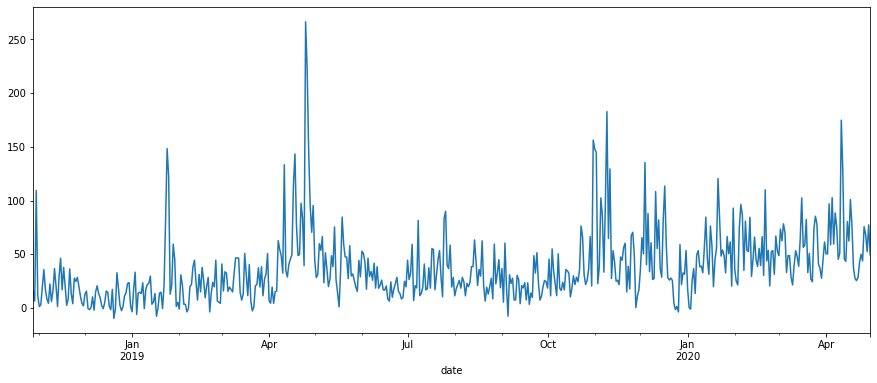

In [26]:
aragon_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [27]:
aragon_slice2['actions'] = aragon_slice2['actions'] - decomposition2.seasonal
aragon_slice2.dropna(inplace=True)

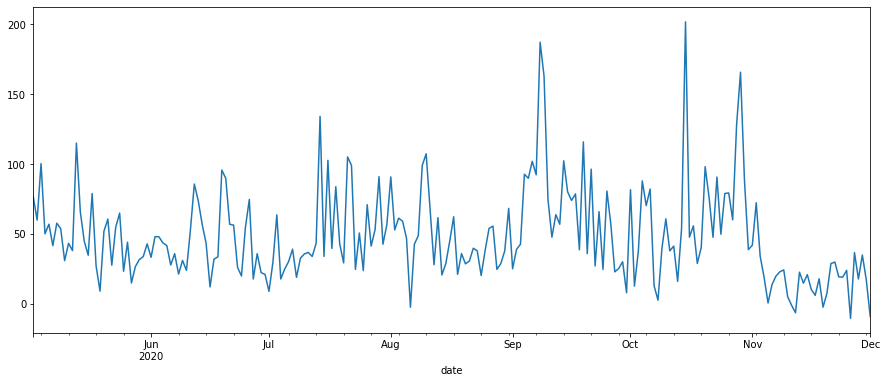

In [28]:
aragon_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [29]:
print_adf(df=aragon_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.072311
P-Value                   0.001076
# Lags Used               7.000000
# Observations Used     543.000000
Critical Value (1%)      -3.442450
Critical Value (5%)      -2.866877
Critical Value (10%)     -2.569613
dtype: float64


In [30]:
print_adf(df=aragon_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.806900
P-Value                   0.002838
# Lags Used               4.000000
# Observations Used     209.000000
Critical Value (1%)      -3.462032
Critical Value (5%)      -2.875471
Critical Value (10%)     -2.574195
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [31]:
print_kpss(df=aragon_slice1, key='actions')

KPSS Statistic: 1.3124824359736367
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [32]:
print_kpss(df=aragon_slice2, key='actions')

KPSS Statistic: 0.18948531954589937
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

## Phillips–Perron (PP) test

In [33]:
pptest = pm.arima.PPTest()
pptest.should_diff(aragon_slice1['actions'])

(0.01, False)

In [34]:
pptest.should_diff(aragon_slice2['actions'])

(0.01, False)

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [35]:
slice1: pd.DataFrame = pd.DataFrame(
    {'actions': aragon_slice1['actions'].tolist(),
     'gasPrice': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0463  , p=0.8297  , df_denom=547, df_num=1
ssr based chi2 test:   chi2=0.0466  , p=0.8291  , df=1
likelihood ratio test: chi2=0.0466  , p=0.8291  , df=1
parameter F test:         F=0.0463  , p=0.8297  , df_denom=547, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6288  , p=0.1971  , df_denom=544, df_num=2
ssr based chi2 test:   chi2=3.2876  , p=0.1932  , df=2
likelihood ratio test: chi2=3.2778  , p=0.1942  , df=2
parameter F test:         F=1.6288  , p=0.1971  , df_denom=544, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0259  , p=0.3807  , df_denom=541, df_num=3
ssr based chi2 test:   chi2=3.1175  , p=0.3739  , df=3
likelihood ratio test: chi2=3.1086  , p=0.3752  , df=3
parameter F test:         F=1.0259  , p=0.3807  , df_denom=541, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7788  , p=0.5393  

In [36]:
slice2: pd.DataFrame = pd.DataFrame(
    {'actions': aragon_slice2['actions'].tolist(),
     'gasPrice': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4638  , p=0.0641  , df_denom=210, df_num=1
ssr based chi2 test:   chi2=3.5133  , p=0.0609  , df=1
likelihood ratio test: chi2=3.4846  , p=0.0619  , df=1
parameter F test:         F=3.4638  , p=0.0641  , df_denom=210, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1870  , p=0.0433  , df_denom=207, df_num=2
ssr based chi2 test:   chi2=6.5280  , p=0.0382  , df=2
likelihood ratio test: chi2=6.4295  , p=0.0402  , df=2
parameter F test:         F=3.1870  , p=0.0433  , df_denom=207, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2826  , p=0.0802  , df_denom=204, df_num=3
ssr based chi2 test:   chi2=7.0827  , p=0.0693  , df=3
likelihood ratio test: chi2=6.9664  , p=0.0730  , df=3
parameter F test:         F=2.2826  , p=0.0802  , df_denom=204, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9212  , p=0.1083  

# VAR analysis

## Slice 1

In [37]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['actions'] = aragon_slice1['actions'].tolist()

In [38]:
model1 = VAR(slice1)
model1.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,54.19,54.21,3.432e+23,54.20
1,53.86,53.90*,2.454e+23,53.88*
2,53.85,53.93,2.434e+23,53.88
3,53.85,53.96,2.442e+23,53.90
4,53.83*,53.98,2.399e+23*,53.89
5,53.85,54.02,2.429e+23,53.92
6,53.86,54.07,2.461e+23,53.94
7,53.85,54.09,2.444e+23,53.95
8,53.85,54.12,2.436e+23,53.96
9,53.86,54.16,2.464e+23,53.98


In [39]:
results1 = model1.fit(maxlags=4, ic='aic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     19:59:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    53.9578
Nobs:                     547.000    HQIC:                   53.8716
Log likelihood:          -16253.0    FPE:                2.35548e+23
AIC:                      53.8162    Det(Omega_mle):     2.27984e+23
--------------------------------------------------------------------
Results for equation gasValue
                    coefficient         std. error           t-stat            prob
-----------------------------------------------------------------------------------
const        16800762341.745968  2040482534.136515            8.234           0.000
L1.gasValue            0.045161           0.043094            1.048           0.295
L1.actions     -30782304.883677    28617737.1

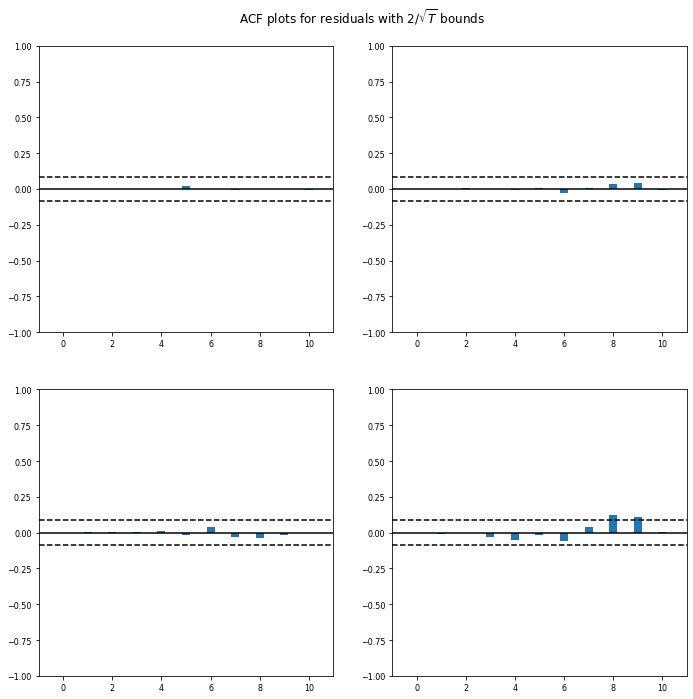

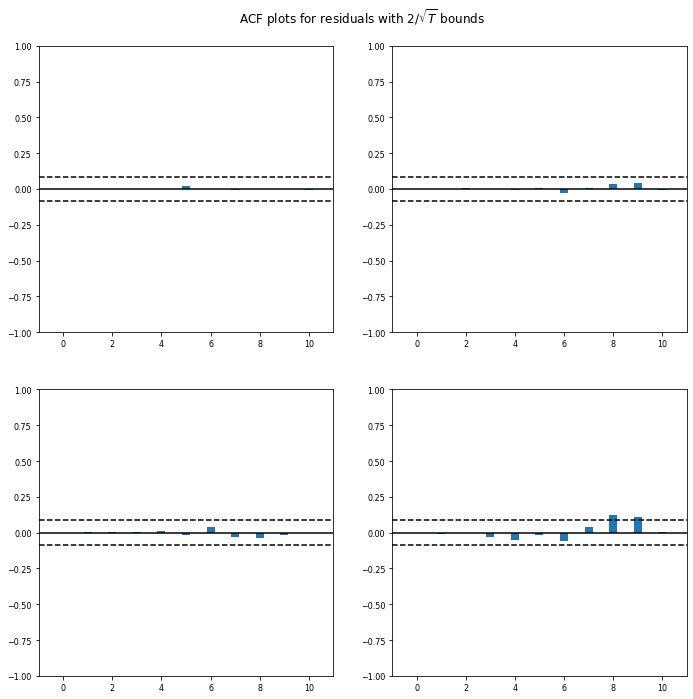

In [40]:
results1.plot_acorr()

### Impulse Response

In [41]:
irf1 = results1.irf(20)

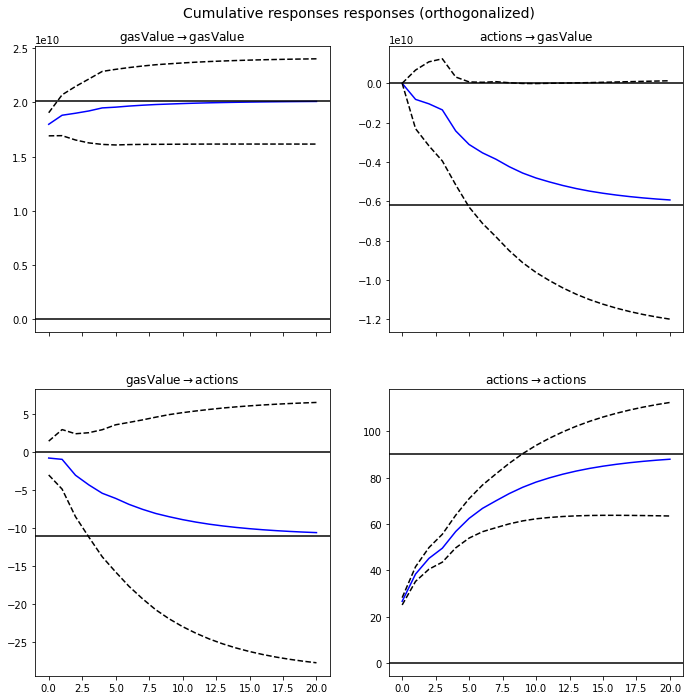

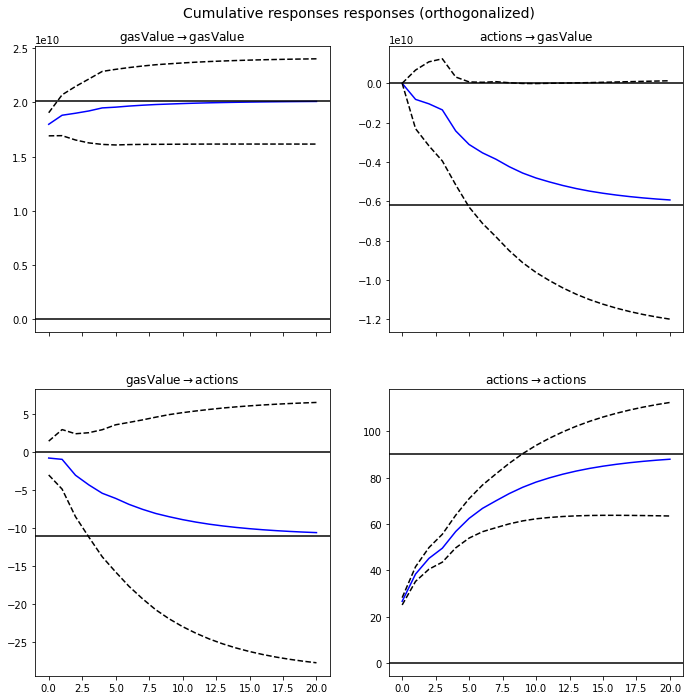

In [42]:
irf1.plot_cum_effects(orth=True)

In [43]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.997938  0.002062
2     0.997781  0.002219
3     0.997489  0.002511
4     0.993978  0.006022
5     0.992529  0.007471
6     0.991980  0.008020
7     0.991665  0.008335
8     0.991220  0.008780
9     0.990906  0.009094
10    0.990713  0.009287
11    0.990592  0.009408
12    0.990493  0.009507
13    0.990420  0.009580
14    0.990368  0.009632
15    0.990333  0.009667
16    0.990307  0.009693
17    0.990288  0.009712
18    0.990275  0.009725
19    0.990265  0.009735

FEVD for actions
      gasValue   actions
0     0.000845  0.999155
1     0.000742  0.999258
2     0.005582  0.994418
3     0.007229  0.992771
4     0.008080  0.991920
5     0.008271  0.991729
6     0.008722  0.991278
7     0.009034  0.990966
8     0.009239  0.990761
9     0.009347  0.990653
10    0.009439  0.990561
11    0.009507  0.990493
12    0.009556  0.990444
13    0.009589  0.990411
14    0.009613  0.990387
15    0.009630  0.990370
16    0.009642

In [44]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
2.036e+06,9.488,0.000,4


In [45]:
results1.test_whiteness(nlags=10).summary()

Test statistic,Critical value,p-value,df
25.98,36.42,0.354,24


In [46]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.4618,3.841,0.497,1


In [47]:
results1.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.7788,2.380,0.539,"(4, 1076)"


## Slice 2

In [48]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = aragon_slice2['actions'].tolist()

In [49]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,57.51,57.54,9.441e+24,57.52
1,56.75,56.85*,4.445e+24,56.79*
2,56.74,56.91,4.396e+24,56.81
3,56.72*,56.95,4.308e+24*,56.81
4,56.74,57.03,4.374e+24,56.86
5,56.75,57.11,4.446e+24,56.90
6,56.78,57.21,4.585e+24,56.96
7,56.82,57.31,4.763e+24,57.02
8,56.82,57.37,4.729e+24,57.04
9,56.85,57.47,4.896e+24,57.10


In [50]:
results2 = model2.fit(maxlags=3, ic='aic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     19:59:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    56.8841
Nobs:                     211.000    HQIC:                   56.7516
Log likelihood:          -6562.61    FPE:                4.05420e+24
AIC:                      56.6617    Det(Omega_mle):     3.79802e+24
--------------------------------------------------------------------
Results for equation gasValue
                    coefficient          std. error           t-stat            prob
------------------------------------------------------------------------------------
const        21563631207.718163  10513388175.975977            2.051           0.040
L1.gasValue            0.768559            0.068032           11.297           0.000
L1.actions     -22808415.550744    150902

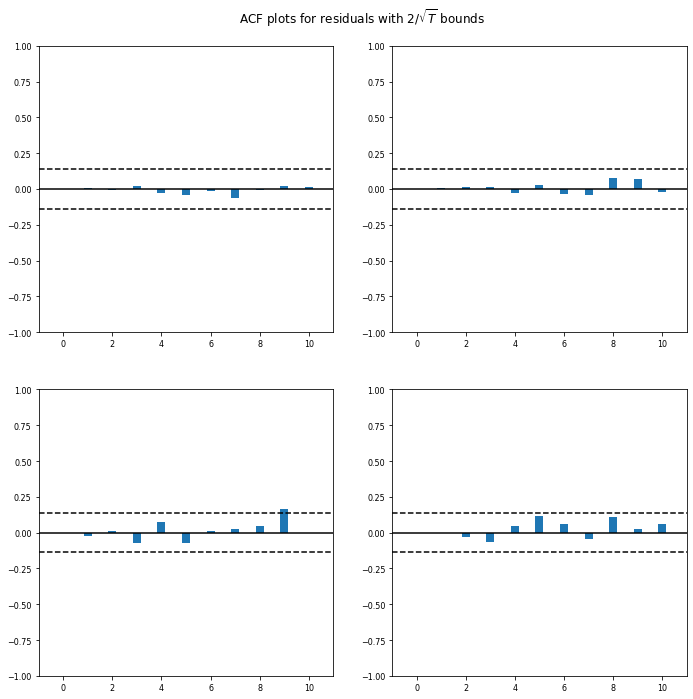

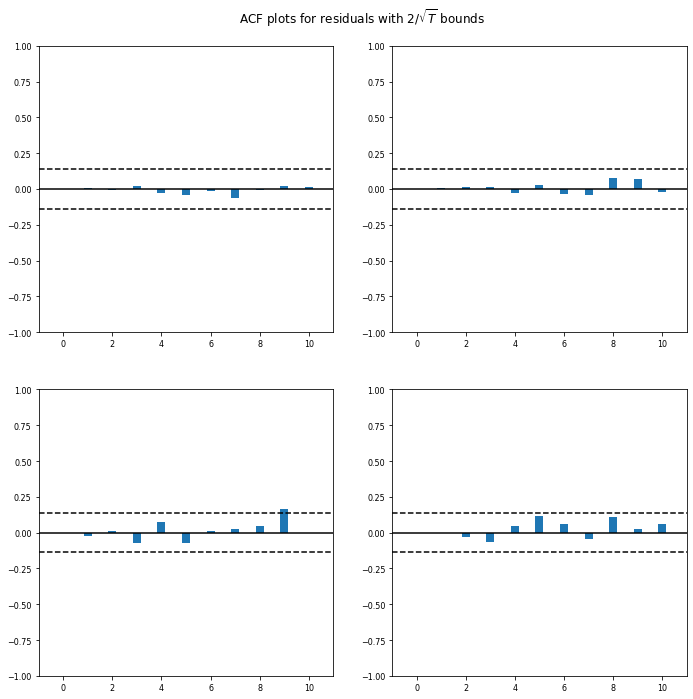

In [51]:
results2.plot_acorr()

### Impulse Response

In [52]:
irf2 = results2.irf(20)

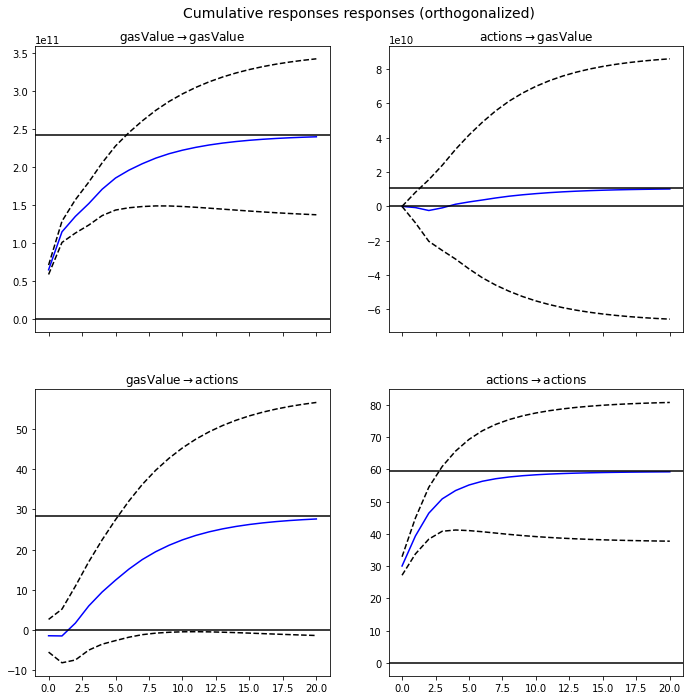

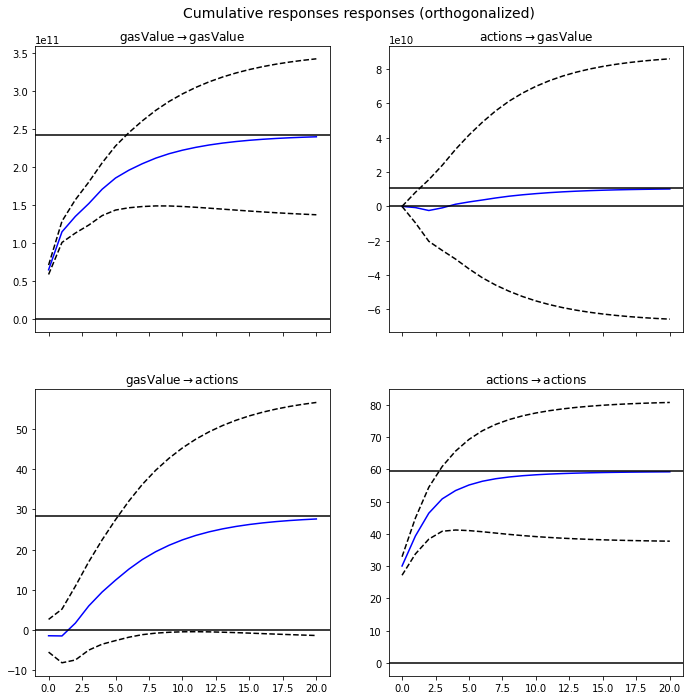

In [53]:
irf2.plot_cum_effects(orth=True)

In [54]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999930  0.000070
2     0.999527  0.000473
3     0.999229  0.000771
4     0.998684  0.001316
5     0.998498  0.001502
6     0.998360  0.001640
7     0.998202  0.001798
8     0.998084  0.001916
9     0.998012  0.001988
10    0.997962  0.002038
11    0.997926  0.002074
12    0.997902  0.002098
13    0.997886  0.002114
14    0.997875  0.002125
15    0.997868  0.002132
16    0.997864  0.002136
17    0.997860  0.002140
18    0.997858  0.002142
19    0.997857  0.002143

FEVD for actions
      gasValue   actions
0     0.002129  0.997871
1     0.001945  0.998055
2     0.011479  0.988521
3     0.027715  0.972285
4     0.038050  0.961950
5     0.045384  0.954616
6     0.051661  0.948339
7     0.056349  0.943651
8     0.059464  0.940536
9     0.061570  0.938430
10    0.063031  0.936969
11    0.064019  0.935981
12    0.064674  0.935326
13    0.065110  0.934890
14    0.065401  0.934599
15    0.065594  0.934406
16    0.065721

In [55]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
7814.,9.488,0.000,4


In [56]:
results2.test_whiteness(nlags=10).summary()

Test statistic,Critical value,p-value,df
24.08,41.34,0.677,28


In [57]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.4482,3.841,0.503,1


In [58]:
results2.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.283,2.627,0.079,"(3, 408)"
